/tmp/ipython-input-2579473121.py:160: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

[**********************67%*******                ]  2 of 3 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

[*********************100%***********************]  3 of 3 completed


--- Librerías importadas ---

--- Librerías importadas ---

--- Clase de Entorno 'PortfolioRebalancingEnv' MODIFICADA (Volatilidad Objetivo) ---

--- Función 'split_data_chronological' definida ---

--- Datos descargados para ['SPY', 'DAX', 'GLD'] ---
Datos totales: 2637 días
Datos de entrenamiento (Train): 2110 días (del 2015-01-02 al 2023-05-19)
Datos de prueba (Test): 527 días (del 2023-05-22 al 2025-06-27)

--- Iniciando entrenamiento PPO (Volatilidad Objetivo: 5.0%) ---
Using cpu device
Logging to ./ppo_portfolio_tesis_log_target_vol/PPO_3



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



-----------------------------
| time/              |      |
|    fps             | 943  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 598          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0067487615 |
|    clip_fraction        | 0.0678       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.69        |
|    explained_variance   | -1.51        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000166     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00574     |
|    std                  | 1.01         |
|    value_loss           | 0.00231      |
----------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



--- Gráfico 'ppo_weights_evolution_vol_objetivo_5.0.html' guardado. ---

¡Error al guardar la imagen PNG! Detalle: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



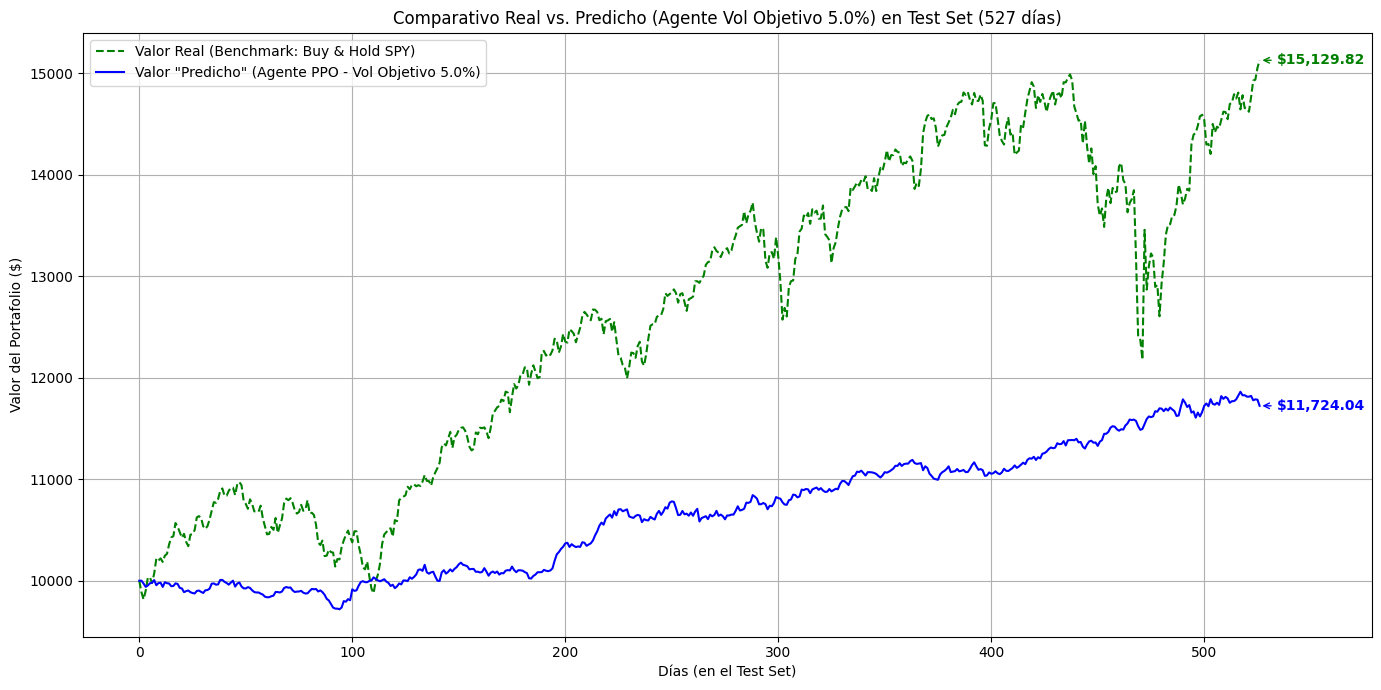

In [ ]:

# 1. INSTALACIONES

!pip install stable-baselines3[extra] gymnasium yfinance pandas numpy matplotlib

print("\n--- Librerías importadas ---")


# 2. IMPORTACIONES

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import deque
import warnings
import matplotlib.ticker as mtick # Importar aquí para la Sección 9

warnings.filterwarnings('ignore', category=FutureWarning, module='yfinance')

print("\n--- Librerías importadas ---")


# 3. EL ENTORNO (¡MODIFICADO con Recompensa de Volatilidad Objetivo!)

class PortfolioRebalancingEnv(gym.Env):
    """
    Entorno de Gymnasium para rebalanceo de portafolio.

    *** NUEVO: El objetivo es alcanzar una VOLATILIDAD OBJETIVO ANUAL. ***
    """
    def __init__(self, data, initial_balance=10000, transaction_cost_pct=0.001,
                 reward_window_size=20, target_annual_volatility=0.05): # <-- NUEVO PARÁMETRO
        super(PortfolioRebalancingEnv, self).__init__()
        self.data = data
        self.n_steps, self.n_assets = data.shape
        self.asset_names = data.columns.tolist()
        self.initial_balance = initial_balance
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_window_size = reward_window_size
        self.return_history = deque(maxlen=self.reward_window_size)

        # --- Lógica de Recompensa (¡NUEVO!) ---
        self.target_annual_volatility = target_annual_volatility
        # Convertir el objetivo anual a un objetivo de volatilidad DIARIA
        self.target_daily_volatility = self.target_annual_volatility / np.sqrt(252)

        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets + 1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(2 * self.n_assets + 1,), dtype=np.float32)
        self.initial_asset_prices = self.data.iloc[0].values
        self.current_step = 0
        self.balance = 0
        self.holdings = np.zeros(self.n_assets)
        self.asset_prices = np.zeros(self.n_assets)
        self.portfolio_value_history = []
        self.reset()

    def _get_observation(self):
        safe_initial_prices = np.where(self.initial_asset_prices == 0, 1, self.initial_asset_prices)
        normalized_prices = self.asset_prices / safe_initial_prices
        normalized_holdings = (self.holdings * self.asset_prices) / self.initial_balance
        normalized_balance = self.balance / self.initial_balance
        obs = np.concatenate([normalized_prices, normalized_holdings, [normalized_balance]]).astype(np.float32)
        return obs
    def _get_info(self):
        portfolio_value = self.balance + np.sum(self.holdings * self.asset_prices)
        return {"portfolio_value": portfolio_value, "balance": self.balance,
                "holdings": self.holdings, "asset_prices": self.asset_prices}
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.holdings = np.zeros(self.n_assets)
        self.asset_prices = self.data.iloc[self.current_step].values
        self.portfolio_value_history = [self.initial_balance]
        self.return_history.clear()
        # Pre-llenar el historial con retornos de 0 para tener una base
        self.return_history.extend([0.0] * self.reward_window_size)
        observation = self._get_observation()
        info = self._get_info()
        return observation, info
    def step(self, action):
        previous_portfolio_value = self.balance + np.sum(self.holdings * self.asset_prices)
        action_sum = np.sum(action)
        if action_sum <= 1e-6:
            weights = np.zeros(self.n_assets + 1); weights[-1] = 1.0
        else:
            weights = action / action_sum
        target_weights = weights[:-1]; cash_weight = weights[-1]
        total_value_to_rebalance = previous_portfolio_value
        target_asset_values = total_value_to_rebalance * target_weights
        trade_costs = 0
        new_holdings = np.zeros(self.n_assets)
        for i in range(self.n_assets):
            current_value = self.holdings[i] * self.asset_prices[i]
            delta_value = target_asset_values[i] - current_value
            if self.asset_prices[i] > 1e-6:
                delta_shares = delta_value / self.asset_prices[i]
                cost = abs(delta_value) * self.transaction_cost_pct
                trade_costs += cost
                new_holdings[i] = self.holdings[i] + delta_shares
            else:
                new_holdings[i] = self.holdings[i]
        self.balance = (total_value_to_rebalance * cash_weight) - trade_costs
        self.holdings = new_holdings
        self.current_step += 1
        terminated = self.current_step >= (self.n_steps - 1)
        truncated = False
        self.asset_prices = self.data.iloc[self.current_step].values
        current_portfolio_value = self.balance + np.sum(self.holdings * self.asset_prices)
        if previous_portfolio_value <= 1e-6: daily_return = 0.0
        else: daily_return = (current_portfolio_value - previous_portfolio_value) / previous_portfolio_value

        self.return_history.append(daily_return)


        # Calcular la volatilidad diaria de la ventana
        rolling_std = np.std(self.return_history)

        # Calcular el error (diferencia absoluta) con el objetivo
        error = np.abs(rolling_std - self.target_daily_volatility)

        # La recompensa es el NEGATIVO del error.
        # Minimizar el error = Maximizar la recompensa.
        reward = -error


        self.portfolio_value_history.append(current_portfolio_value)
        observation = self._get_observation()
        info = self._get_info()
        return observation, reward, terminated, truncated, info

print("\n--- Clase de Entorno 'PortfolioRebalancingEnv' MODIFICADA (Volatilidad Objetivo) ---")


# 4. FUNCIÓN PARA DIVIDIR LOS DATOS

def split_data_chronological(data, test_size_pct=0.2):
    n_total = len(data); n_test = int(n_total * test_size_pct); n_train = n_total - n_test
    data_train = data.iloc[:n_train]; data_test = data.iloc[n_train:]
    print(f"Datos totales: {n_total} días")
    print(f"Datos de entrenamiento (Train): {len(data_train)} días (del {data_train.index.min().date()} al {data_train.index.max().date()})")
    print(f"Datos de prueba (Test): {len(data_test)} días (del {data_test.index.min().date()} al {data_test.index.max().date()})")
    return data_train, data_test
print("\n--- Función 'split_data_chronological' definida ---")


# 5. CARGA Y DIVISIÓN DE DATOS

tickers = ['SPY', 'DAX', 'GLD']
start_date = '2015-01-01'
end_date = '2025-06-30'
INITIAL_BALANCE = 10000
TARGET_VOLATILITY_PCT = 0.05 # <-- ¡NUESTRO OBJETIVO!

data = yf.download(tickers, start=start_date, end=end_date)['Close']
data.ffill(inplace=True); data.bfill(inplace=True)
print(f"\n--- Datos descargados para {tickers} ---")
data_train, data_test = split_data_chronological(data, test_size_pct=0.2)


# 6. ENTRENAMIENTO DEL MODELO PPO (¡MODIFICADO!)

print(f"\n--- Iniciando entrenamiento PPO (Volatilidad Objetivo: {TARGET_VOLATILITY_PCT*100}%) ---")
env_train = PortfolioRebalancingEnv(
    data_train,
    initial_balance=INITIAL_BALANCE,
    reward_window_size=20,
    target_annual_volatility=TARGET_VOLATILITY_PCT # Pasar el nuevo parámetro
)
env_train = DummyVecEnv([lambda: env_train])

model = PPO("MlpPolicy", env_train, verbose=1,
            tensorboard_log="./ppo_portfolio_tesis_log_target_vol/") #Log modificado

TIMESTEPS_TO_TRAIN = 200000
model.learn(total_timesteps=TIMESTEPS_TO_TRAIN)

print(f"\n--- Entrenamiento completado tras {TIMESTEPS_TO_TRAIN} timesteps ---")



# 7. EVALUACIÓN (OUT-OF-SAMPLE) - Probando el modelo en los datos de TEST

print(f"\n--- Evaluando el modelo (Volatilidad Objetivo: {TARGET_VOLATILITY_PCT*100}%) en el set de 'TEST' ---") # <-- Título modificado

env_eval_test = PortfolioRebalancingEnv(
    data_test,
    initial_balance=INITIAL_BALANCE,
    reward_window_size=20,
    target_annual_volatility=TARGET_VOLATILITY_PCT # Pasar el nuevo parámetro
)
obs, info = env_eval_test.reset()
done = False
truncated = False

ppo_test_history = [INITIAL_BALANCE]
weights_history = []

obs, info = env_eval_test.reset()
while not done:
    action, _states = model.predict(obs, deterministic=True)
    weights_history.append(action)
    obs, reward, done, truncated, info = env_eval_test.step(action)
    if not done:
        ppo_test_history.append(info['portfolio_value'])

print("--- Evaluación 'Out-of-Sample' (Test) completada ---")


# 8. CÁLCULO DE TABLAS y BENCHMARK ("VALOR REAL")

#  Procesar el historial de pesos
normalized_weights_history = [w / np.sum(w) for w in weights_history]
asset_columns = tickers + ['Cash']
weights_df = pd.DataFrame(normalized_weights_history, columns=asset_columns)

# --- Calcular métricas de rendimiento ---
returns_test = pd.Series(ppo_test_history).pct_change().dropna()
volatilidad_test = returns_test.std() * np.sqrt(252) # Esta es la volatilidad OBTENIDA
sharpe_ratio_test = 0.0
if volatilidad_test > 1e-6:
    retorno_esperado_test = returns_test.mean() * 252
    sharpe_ratio_test = retorno_esperado_test / volatilidad_test
else:
    retorno_esperado_test = 0.0

# --- Calcular Pesos PROMEDIO ---
avg_weights = weights_df.mean()
w_spy_avg = avg_weights['SPY']
w_dax_avg = avg_weights['DAX']
w_gld_avg = avg_weights['GLD']
w_cash_avg = avg_weights['Cash']


# --- Imprimir la tabla de resultados PROMEDIO (¡MODIFICADO!) ---
summary_data_avg = {
    'Portafolio': [f'PPO (RL) - Vol Objetivo {TARGET_VOLATILITY_PCT*100}% (Test)'], # <-- Etiqueta modificada
    'Retorno Esperado': [retorno_esperado_test],
    'Volatilidad (Obtenida)': [volatilidad_test], # <-- Etiqueta modificada
    'Sharpe Ratio': [sharpe_ratio_test],
    'W_SPY (Promedio)': [w_spy_avg],
    'W_DAX (Promedio)': [w_dax_avg],
    'W_GLD (Promedio)': [w_gld_avg],
    'W_Cash (Promedio)': [w_cash_avg],
}
df_resultado_promedio_rl = pd.DataFrame(summary_data_avg)

print("\n\n" + "="*70)
print(f"  RESULTADO PROMEDIO DE EVALUACIÓN (TEST SET) - PPO VOLATILIDAD OBJETIVO {TARGET_VOLATILITY_PCT*100}%") # <-- Título modificado
print("="*70)
print(df_resultado_promedio_rl.to_markdown(index=False))

# --- Calcular Benchmark "Buy & Hold SPY" ("Valor Real") ---
print("\n--- Calculando Benchmark 'Buy & Hold SPY' ('Valor Real') ---")
spy_test_history = (data_test['SPY'] / data_test['SPY'].iloc[0]) * INITIAL_BALANCE


# 9. GRÁFICO COMPARATIVO (REAL vs. PREDICHO en Set de TEST)

print("Generando gráfico 1: 'Real' vs. 'Predicho' (Test Set)")

# --- 1. CORRECCIÓN de longitud ---
try:
    ppo_test_history_data = env_eval_test.portfolio_value_history
    if len(ppo_test_history_data) != len(spy_test_history.values):
        print(f"Error: Las longitudes no coinciden. PPO: {len(ppo_test_history_data)}, SPY: {len(spy_test_history.values)}")
        min_len = min(len(ppo_test_history_data), len(spy_test_history.values))
        ppo_test_history_data = ppo_test_history_data[:min_len]
        spy_test_history_data = spy_test_history.values[:min_len]
    else:
        spy_test_history_data = spy_test_history.values
        print("Longitudes de PPO y SPY coinciden. Generando gráfico...")
except NameError:
    print("Error: 'env_eval_test' no encontrado.")
    ppo_test_history_data = [10000]; spy_test_history_data = [10000]



# --- 2. Creación del Gráfico)
plt.figure(figsize=(14, 7))
plt.plot(spy_test_history_data, label='Valor Real (Benchmark: Buy & Hold SPY)', color='green', linestyle='--')
plt.plot(ppo_test_history_data, label=f'Valor "Predicho" (Agente PPO - Vol Objetivo {TARGET_VOLATILITY_PCT*100}%)', color='blue') # <-- Etiqueta modificada
plt.title(f'Comparativo Real vs. Predicho (Agente Vol Objetivo {TARGET_VOLATILITY_PCT*100}%) en Test Set ({len(data_test)} días)') # <-- Título modificado
plt.xlabel('Días (en el Test Set)')
plt.ylabel('Valor del Portafolio ($)')
plt.grid(True)

# --- 3. Añadir las etiquetas finales ---
x_final = len(ppo_test_history_data) - 1
y_final_ppo = ppo_test_history_data[-1]
y_final_spy = spy_test_history_data[-1]
label_ppo = f'${y_final_ppo:,.2f}'
label_spy = f'${y_final_spy:,.2f}'

plt.annotate(
    label_ppo, xy=(x_final, y_final_ppo), xytext=(x_final + 8, y_final_ppo),
    textcoords='data', color='blue', fontweight='bold', va='center',
    arrowprops=dict(arrowstyle="->", color='blue', connectionstyle="arc3")
)
plt.annotate(
    label_spy, xy=(x_final, y_final_spy), xytext=(x_final + 8, y_final_spy),
    textcoords='data', color='green', fontweight='bold', va='center',
    arrowprops=dict(arrowstyle="->", color='green', connectionstyle="arc3")
)

# --- 4. Ajustar el gráfico para que quepa el texto ---
plt.xlim(right=x_final * 1.10)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f'ppo_real_vs_predicho_test_set_vol_objetivo_{TARGET_VOLATILITY_PCT*100}.png') # <-- Nombre de archivo modificado
print(f"Gráfico 'ppo_real_vs_predicho_test_set_vol_objetivo_{TARGET_VOLATILITY_PCT*100}.png' generado.")


# ==============================================================================
# 10. ¡NUEVO GRÁFICO! - Evolución de Pesos (¡GRÁFICO INTERACTIVO con Plotly!)
# ==============================================================================

# --- Instalar Kaleido y Chrome (si es necesario) ---
!pip install -U kaleido
!plotly_get_chrome

print("\n--- Generando gráfico 2: Evolución de Pesos del Portafolio (Test Set) ---")

# --- 1. Importar las librerías necesarias ---
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_white"

# --- 2. Preparar los datos para Plotly (Formato "Largo") ---
weights_df_plotly = weights_df.reset_index().rename(columns={'index': 'Día'})
weights_df_long = weights_df_plotly.melt(
    id_vars='Día',
    var_name='Activo',
    value_name='Proporción'
)

# --- 3. Definir los mismos colores profesionales ---
color_map = {
    'W_SPY': '#007ACC',
    'W_DAX': '#FAA43A',
    'W_GLD': '#60BD68',
    'W_Cash': '#F17CB0'
}

# --- 4. Crear el gráfico de área interactivo (¡MODIFICADO!) ---
fig = px.area(
    weights_df_long,
    x='Día',
    y='Proporción',
    color='Activo',
    labels={'Día': 'Días (en el set de prueba)', 'Proporción': 'Proporción del Portafolio', 'Activo': 'Activos'},
    title=f'Evolución de Pesos (PPO Vol Objetivo {TARGET_VOLATILITY_PCT*100}%) en Set de Prueba ({len(weights_df)} días)', # <-- Título modificado
    color_discrete_map=color_map,
    template=pio.templates.default
)

# --- 5. Mejorar el layout y los tooltips (hover) ---
fig.update_layout(
    yaxis_tickformat='.1%',
    xaxis_title='Días (en el set de prueba)',
    yaxis_title='Proporción del Portafolio',
    legend_title='Activos',
    hovermode="x unified"
)

# --- 6. Mostrar el gráfico interactivo en el notebook ---
print("Mostrando gráfico interactivo...")
fig.show()

# --- 7. Guardar el gráfico ---
fig.write_html(f'ppo_weights_evolution_vol_objetivo_{TARGET_VOLATILITY_PCT*100}.html') # <-- Nombre de archivo modificado
print(f"--- Gráfico 'ppo_weights_evolution_vol_objetivo_{TARGET_VOLATILITY_PCT*100}.html' guardado. ---")

try:
    fig.write_image(f'ppo_weights_evolution_vol_objetivo_{TARGET_VOLATILITY_PCT*100}.png', scale=2) # <-- Nombre de archivo modificado
    print(f"--- Gráfico 'ppo_weights_evolution_vol_objetivo_{TARGET_VOLATILITY_PCT*100}.png' guardado. ---")
except Exception as e:
    print(f"\n¡Error al guardar la imagen PNG! Detalle: {e}")

# --- Opcional: Volver al estilo por defecto para matplotlib ---
plt.style.use('default')